Let's import `pandas` and `numpy` for data structures, and `seaborn` and `matplotlib` for viz. We also want to import `scooby` so we can see what version of `sklearn` and `seaborn` we have installed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scooby
import seaborn as sns

sns.set()  # make it pretty
import sklearn  # for label encoding

%matplotlib inline

Run a `scooby` report to see what versions we have installed

In [2]:
scooby.Report(additional=[sklearn, sns])

--------------------------------------------------------------------------------
  Date: Tue Nov 17 10:15:54 2020 CST

                OS : Darwin
            CPU(s) : 12
           Machine : x86_64
      Architecture : 64bit
               RAM : 16.0 GB
       Environment : Jupyter

  Python 3.7.3 (default, Mar 27 2019, 16:54:48)  [Clang 4.0.1
  (tags/RELEASE_401/final)]

           sklearn : 0.21.2
           seaborn : 0.9.0
             numpy : 1.16.4
             scipy : 1.3.0
           IPython : 7.6.1
        matplotlib : 3.1.0
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

Read in the data with `pandas` and take a look at how it is structured

In [3]:
data = pd.read_excel("RCOMPL_RIG_SCALED.xlsx")  # read it in
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 82 columns):
Unnamed: 0                       964 non-null int64
#WELL_NAME                       964 non-null object
CURRENT_STATUS                   964 non-null object
UWI                              964 non-null int64
UWI_SIDETRACK                    964 non-null int64
JOB_CATEGORY                     964 non-null object
JOB_START_DATE                   964 non-null object
JOB_END_DATE                     360 non-null object
JOB_STATUS                       500 non-null object
LIKE_KIND                        919 non-null object
PROJECT_TYPE                     964 non-null object
PHASE_START_DATE                 960 non-null object
PHASE_END_DATE                   918 non-null object
PHASE                            964 non-null object
JOB_OP_CODE                      964 non-null object
RIG_ID                           964 non-null object
RIG_ACCEPT_DATE                  964 non-null date

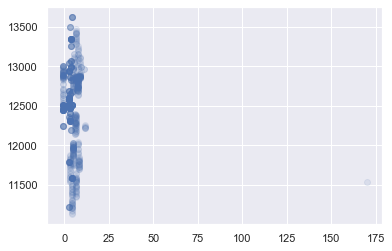

In [4]:
plt.scatter(data.Errors_Per_Stage, data.TOP_DEPTH_TVD, alpha=0.1)

Looks good, but let's see if we can separate what looks like two different groups of data. What if we color it by depth?

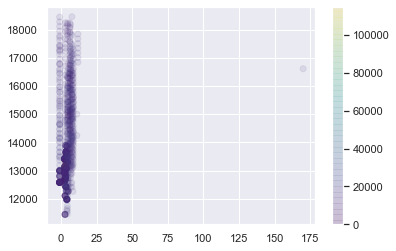

In [5]:
plt.scatter(data.Errors_Per_Stage, data.STG_TOP_DEPTH, c=data.MAX_PUMP_POWER, cmap="viridis", alpha=0.1)
plt.colorbar()

That looks like the shallow data samples have a different relationship than the deeper samples. We should investigate this further. But first let's go ahead and get rid of the qualitative `TOP` data

In [6]:
data = data.drop( columns = 'STG_START_DATE')
data = data.drop( columns = 'STG_END_DATE')
data = data.drop( columns = 'RIG_ACCEPT_DATE')
data = data.drop( columns = 'RIG_RELEASE_DATE')



clean_data = data[data.T[data.dtypes!=np.object].index]
clean_data = clean_data.fillna(0)
clean_data.count()

Unnamed: 0                       964
UWI                              964
UWI_SIDETRACK                    964
REPORT_START_DATE_YEAR           964
FRAC_GRADIENT                    964
BREAKDOWN_PRESSURE               964
HYDROSTATIC_PRESSURE             964
TREAT_AVG_PRESSURE               964
TREAT_MAX_PRESSURE               964
TREAT_MIN_PRESSURE               964
PROPPANT_DESIGNED                964
PROPPANT_IN_FORMATION            964
PROPPANT_IN_WELLBORE             964
AVG_HYDRAULIC_POWER              964
MAX_PUMP_POWER                   964
MAX_PUMP_RATING                  964
TREAT_AVG_RATE                   964
TREAT_MAX_RATE                   964
TREAT_MIN_RATE                   964
POST_INSTANT_SHUT_IN_PRESSURE    964
INITIAL_SHUT_IN_PRESSURE         964
PRE_INSTANT_SHUT_IN_PRESSURE     964
STG_NUMBER                       964
STG_TOP_DEPTH                    964
STG_BOTTOM_DEPTH                 964
STG_ELEMENT_TOP_DEPTH            964
STG_ELEMENT_BOTTOM_DEPTH         964
S

Next we want to scale our features, and assign our two features we are going to use in our clustering

In [7]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
scaled_data = pd.DataFrame(
    scaler.fit_transform(clean_data.values),
    columns=clean_data.columns,
    index=clean_data.index,
)
X = scaled_data[['Errors_Per_Stage','TOP_DEPTH_TVD']]

We will start with `KMeans` clustering and see how it does. We just need to import it and fit it ot our dataset

In [8]:
from sklearn.cluster import SpectralClustering

In [9]:
cluster = SpectralClustering()
cluster.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=8, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=None)

After we fit our `KMeans` algorithm, we have labels for each point in the dataset. We want to add this to our dataframe 

In [10]:
X = X.assign(Label=cluster.labels_)

In [11]:
X.describe()

,Errors_Per_Stage,TOP_DEPTH_TVD,Label
count,9.640000e+02,9.640000e+02,964.000000
mean,2.096339e-09,6.144818e-06,4.772822
std,2.979519e-09,5.549768e-07,1.254379
min,-4.952946e-10,0.000000e+00,0.000000
25%,1.337295e-09,6.044449e-06,5.000000
50%,1.926145e-09,6.196630e-06,5.000000
75%,3.111069e-09,6.372954e-06,5.000000
max,8.420008e-08,6.748881e-06,7.000000


Let's look at the cluster labels and see how `KMeans` did with just two features.

In [12]:
X.Errors_Per_Stage = (1e6)*X.Errors_Per_Stage
X.TOP_DEPTH_TVD = (1e6)*X.TOP_DEPTH_TVD
X.describe()

,Errors_Per_Stage,TOP_DEPTH_TVD,Label
count,964.000000,964.000000,964.000000
mean,0.002096,6.144818,4.772822
std,0.002980,0.554977,1.254379
min,-0.000495,0.000000,0.000000
25%,0.001337,6.044449,5.000000
50%,0.001926,6.196630,5.000000
75%,0.003111,6.372954,5.000000
max,0.084200,6.748881,7.000000


(-0.029529, 0.07)

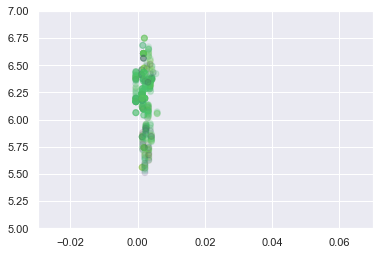

In [13]:
plt.scatter(
    X.Errors_Per_Stage,
    X.TOP_DEPTH_TVD,
    c=X.Label,
    cmap="viridis",
    alpha=0.1,
)
plt.ylim(5,7)
plt.xlim(-0.029529,.07)

That seems to be a let down with how it partitioned our our data in two dimensions. What if we try `DBSCAN` clustering?

In [14]:
from sklearn.cluster import DBSCAN

In [15]:
db = DBSCAN(eps=0.1, algorithm="auto", min_samples=15)
db.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

(-0.029529, 0.07)

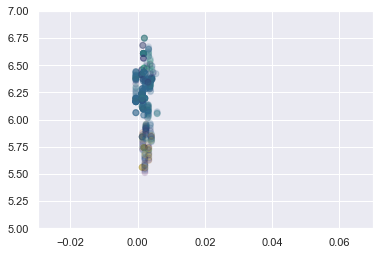

In [16]:
X = X.assign(DBLabels=db.labels_)
plt.scatter(
    X.Errors_Per_Stage,
    X.TOP_DEPTH_TVD,
    c=X.DBLabels,
    cmap="viridis",
    alpha=0.1,
)
plt.ylim(5,7)
plt.xlim(-0.029529,.07)

Still disappointing to say the least. Let's get rid of our labels and bring in all the different features we have available in the dataset

In [17]:
X = scaled_data

In [18]:
X.head()

,Unnamed: 0,UWI,UWI_SIDETRACK,REPORT_START_DATE_YEAR,FRAC_GRADIENT,BREAKDOWN_PRESSURE,HYDROSTATIC_PRESSURE,TREAT_AVG_PRESSURE,TREAT_MAX_PRESSURE,TREAT_MIN_PRESSURE,...,TOP_DEPTH_TVD,BOTTOM_DEPTH_TVD,PROPOSED,Rig_Duration (days),Stg_Duration (hrs),Stage_Length (meters),Prod_Per_Stage,Errors_Per_Stage,AVG PRESSURE (PSI),AVG HHP
0,0.000000e+00,1.0,0.0,9.995043e-07,0.000000e+00,0.000004,0.000003,0.000004,0.000005,2.773649e-08,...,0.000006,0.000006,0.0,2.971767e-09,9.905890e-10,2.970281e-06,3.373341e-06,1.265753e-09,0.000004,0.000007
1,4.952946e-10,1.0,0.0,9.999998e-07,4.952946e-10,0.000003,0.000003,0.000005,0.000005,0.000000e+00,...,0.000006,0.000006,0.0,4.952946e-09,4.952946e-10,7.280831e-08,7.067671e-07,2.540678e-09,0.000005,0.000010
2,9.905892e-10,1.0,0.0,9.999998e-07,4.952946e-10,0.000003,0.000003,0.000005,0.000005,0.000000e+00,...,0.000006,0.000006,0.0,4.952946e-09,4.952946e-10,7.280831e-08,7.067671e-07,2.540678e-09,0.000005,0.000009
3,1.485884e-09,1.0,0.0,9.995043e-07,0.000000e+00,0.000004,0.000003,0.000004,0.000004,3.796928e-06,...,0.000006,0.000006,0.0,2.971767e-09,9.905890e-10,2.970281e-06,3.373341e-06,1.265753e-09,0.000004,0.000007
4,1.981178e-09,1.0,0.0,9.999996e-07,4.952945e-10,0.000003,0.000003,0.000005,0.000005,0.000000e+00,...,0.000006,0.000006,0.0,4.952945e-09,9.905890e-10,7.379888e-08,3.661811e-07,3.665179e-09,0.000005,0.000008


This seems to be a bit more reasonable. We have some overlapping clusters, and we see a couple of clusters with different slopes like we noticed earlier on. 

What if we try this with `DBSCAN`, how do you think it will do?